In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('./dataset/malaria_detection.csv') 
df.head(10)

,filename,label
0,C50P11thinF_IMG_20150724_114951_cell_148.png,malaria
1,C112P73ThinF_IMG_20150930_131659_cell_94.png,healthy
2,C59P20thinF_IMG_20150803_111333_cell_144.png,malaria
3,C158P119ThinF_IMG_20151115_181136_cell_202.png,malaria
4,C81P42ThinF_IMG_20150817_120524_cell_190.png,malaria
5,C130P91ThinF_IMG_20151004_142709_cell_110.png,healthy
6,C48P9thinF_IMG_20150721_160406_cell_231.png,malaria
7,C182P143NThinF_IMG_20151201_172257_cell_169.png,malaria
8,C159P120ThinF_IMG_20151115_185541_cell_182.png,malaria
9,C184P145ThinF_IMG_20151203_103114_cell_153.png,malaria


In [3]:
df.isnull().sum()

filename    0
label       0
dtype: int64

In [4]:
from sklearn.preprocessing import LabelEncoder
enc=LabelEncoder()
df["label"]=enc.fit_transform(df["label"])
df.head(10)

,filename,label
0,C50P11thinF_IMG_20150724_114951_cell_148.png,1
1,C112P73ThinF_IMG_20150930_131659_cell_94.png,0
2,C59P20thinF_IMG_20150803_111333_cell_144.png,1
3,C158P119ThinF_IMG_20151115_181136_cell_202.png,1
4,C81P42ThinF_IMG_20150817_120524_cell_190.png,1
5,C130P91ThinF_IMG_20151004_142709_cell_110.png,0
6,C48P9thinF_IMG_20150721_160406_cell_231.png,1
7,C182P143NThinF_IMG_20151201_172257_cell_169.png,1
8,C159P120ThinF_IMG_20151115_185541_cell_182.png,1
9,C184P145ThinF_IMG_20151203_103114_cell_153.png,1


In [5]:
from skimage.io import imread,imshow
from skimage.transform import resize

In [6]:
import os
base_path=os.path.join('./dataset/cell_images/')

In [7]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y=train_test_split(df["filename"], df["label"], test_size=0.2, random_state=42)

In [8]:
train_x.size, test_x.size

(15432, 3858)

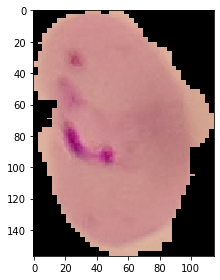

In [9]:
from random import randint
rm=randint(0,17361)
img=imread(os.path.join(base_path,train_x.iloc[rm]))
imshow(img)

In [10]:
img_x=[]
img_y=[]

In [11]:
for i in range(len(train_x)):
    img=imread(os.path.join(base_path,train_x.iloc[i]))
    img_x.append(img.shape[0])
    img_y.append(img.shape[1])
avg_x=sum(img_x)/len(img_x)
avg_y=sum(img_y)/len(img_y)
avg_x,avg_y

(132.99105754276826, 132.51963452566096)

In [12]:
img_dim=(132,132)

In [13]:
from skimage.feature import hog
from skimage.transform import resize

In [14]:
train_features = []
for i in train_x:
    image = imread(os.path.join(base_path,i))
    image = resize(image,img_dim)
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    train_features.append(features)

In [15]:
test_features = []
for i in test_x:
    image = imread(os.path.join(base_path,i))
    image = resize(image,img_dim)
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    test_features.append(features)

In [16]:
train_features=np.array(train_features)
test_features=np.array(test_features)

In [18]:
np.save('train_features', train_features)
np.save('test_features', test_features)

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [30]:
model=Sequential()

#Layer 1
model.add(Dense(128,activation='relu', input_shape=(train_features.shape[1], )))
model.add(LeakyReLU(alpha=0.1))

#Layer 2
model.add(Dense(128, activation='relu'))

#Layer 3
model.add(Dense(128, activation='linear'))

#Output Layer
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist=model.fit(train_features, train_y, batch_size = 32, epochs = 10, validation_data=(test_features, test_y))

Epoch 1/10
483/483 [==============================] - 4s 7ms/step - loss: 0.6189 - accuracy: 0.6502 - val_loss: 0.4988 - val_accuracy: 0.7716
Epoch 2/10
483/483 [==============================] - 3s 7ms/step - loss: 0.4815 - accuracy: 0.7661 - val_loss: 0.4546 - val_accuracy: 0.7836
Epoch 3/10
483/483 [==============================] - 3s 7ms/step - loss: 0.4319 - accuracy: 0.7957 - val_loss: 0.4969 - val_accuracy: 0.7605
Epoch 4/10
483/483 [==============================] - 3s 7ms/step - loss: 0.3939 - accuracy: 0.8188 - val_loss: 0.5224 - val_accuracy: 0.7623
Epoch 5/10
483/483 [==============================] - 3s 7ms/step - loss: 0.3717 - accuracy: 0.8305 - val_loss: 0.4475 - val_accuracy: 0.7989
Epoch 6/10
483/483 [==============================] - 3s 7ms/step - loss: 0.3439 - accuracy: 0.8465 - val_loss: 0.4830 - val_accuracy: 0.7812
Epoch 7/10
483/483 [==============================] - 3s 7ms/step - loss: 0.3438 - accuracy: 0.8458 - val_loss: 0.4586 - val_accuracy: 0.7965
Epoch 

In [31]:
val_loss, val_acc = model.evaluate(test_features, test_y)

print("Loss: ",val_loss)
print("Accuracy : ",val_acc)

121/121 [==============================] - 0s 2ms/step - loss: 0.4787 - accuracy: 0.7996
Loss:  0.47865524888038635
Accuracy :  0.7996371388435364
